In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
torch.cuda.get_device_name()

'NVIDIA A100-SXM4-40GB'

In [4]:
# Define the LightningModule
class CIFAR10ResNet(pl.LightningModule):
    def __init__(self, learning_rate=1e-2):
        super().__init__()
        self.save_hyperparameters()
        self.model = resnet18(num_classes=10)
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [5]:
# Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [6]:
dataset = CIFAR10(root='data', train=True, download=True, transform=transform)
train_data, val_data = random_split(dataset, [45000, 5000])
train_loader = DataLoader(train_data, batch_size=64, num_workers=4, shuffle=True, persistent_workers=True)
val_loader = DataLoader(val_data, batch_size=64, num_workers=4, shuffle=False, persistent_workers=True)

Files already downloaded and verified


In [7]:
# Logger and checkpoint
csv_logger = CSVLogger("logs", name="cifar10_resnet18")
checkpoint_callback = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1)

In [8]:
# Model Training
model = CIFAR10ResNet()
torch.set_float32_matmul_precision('medium')
trainer = Trainer(
    max_epochs=20, 
    accelerator="gpu" if torch.cuda.is_available() else "cpu", 
    devices=-1,  # Set devices to -1 for both GPU and CPU
    logger=csv_logger, 
    callbacks=[checkpoint_callback],
    log_every_n_steps=2
)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


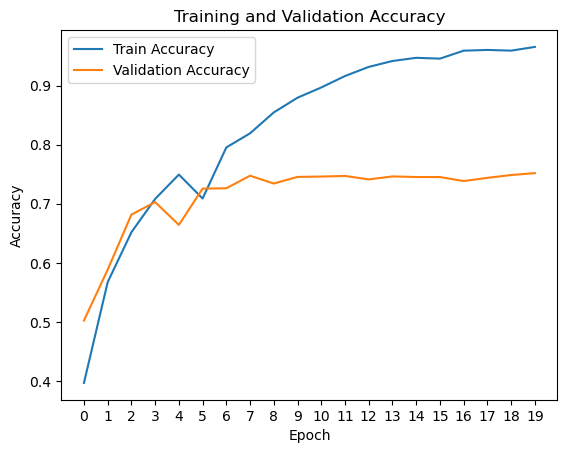

In [20]:
# Plotting training and validation accuracies
history = csv_logger.experiment.metrics_file_path
data = pd.read_csv(history)
data_train = data.dropna(subset=['train_acc'])
data_val = data.dropna(subset=['val_acc'])

%matplotlib inline
fig, ax = plt.subplots()
ax.plot(data_train['epoch'], data_train['train_acc'], label='Train Accuracy')
ax.plot(data_val['epoch'], data_val['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=[i for i in range(20)])
ax.legend(loc='best')
plt.title('Training and Validation Accuracy')
plt.show()
fig.savefig('Accuracy.png')